In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from MySQLdb import connect
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [20]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.spec_layer = nn.Linear(29, 64)
        self.geo_layer = nn.Linear(7, 64)
        
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 19)
    
    def forward(self, spec, geo):
        spec = self.spec_layer(spec)
        spec = torch.relu(spec)
        
        geo = self.geo_layer(geo)
        geo = torch.relu(geo)
        
        out = self.fc1(spec + geo)
        out = torch.relu(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        
        return out

In [13]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.spec_layer = nn.Linear(29, 64)
        self.bn_spec = nn.BatchNorm1d(64)
        self.geo_layer = nn.Linear(7, 64)
        self.bn_geo = nn.BatchNorm1d(64)
        
        self.fc1 = nn.Linear(64, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 1)
    
    def forward(self, spec, geo):
        spec = self.spec_layer(spec)
        spec = self.bn_spec(spec)
        spec = torch.relu(spec)
        
        geo = self.geo_layer(geo)
        geo = self.bn_geo(geo)
        geo = torch.relu(geo)
        
        out = self.fc1(spec + geo)
        out = self.bn1(out)
        out = torch.relu(out)
        
        out = self.fc2(out)
        out = self.bn2(out)
        out = torch.relu(out)
        out = self.fc3(out)
        out = torch.clamp(out, 0, 100)
#         out = torch.sigmoid(out)
        
        return out

In [28]:
model = Model2()
# model.to(device)
loss_func = nn.MSELoss(reduction="sum")
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(lr=1e-4, params=model.parameters(), betas=(0.9, 0.999))
# optimizer = optim.SGD(lr=1e-4, params=model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [6]:
conn = connect(
    host="140.112.174.26",
    user="md703",
    passwd="MD703",
    db="ijv"
)
df = pd.read_sql("SELECT * FROM ijv_sim_spec", con=conn)
len(df)

1051

In [7]:
class SpecData(Dataset):
    def __init__(self, df):
        self.df = df
        

    def __getitem__(self, idx):
        i = self.df["idx"][idx]
        path = "train/spec/{}/{}.npy".format(i, i)
        spec = np.load(path)[5] # SDS: 20mm 
        spec = torch.tensor(spec).float()
        
        geo = self.df[["geo_skin", "geo_fat", "geo_ijvr", "geo_ijvd", "geo_ccar", "geo_ccad", "geo_ijvcca"]].values[idx]
        geo = torch.tensor(geo).float()
        
#         param = self.df[['skin_b', 'skin_s', 'skin_w', 'skin_f', 'skin_m', 'fat_f',
#        'muscle_b', 'muscle_s', 'muscle_w', 'ijv_s', 'cca_s', 'skin_musp',
#        'skin_bmie', 'fat_musp', 'fat_bmie', 'muscle_musp', 'muscle_bmie',
#        'ijv_musp', 'cca_musp']].values[idx]
        param = self.df['ijv_s'].values[idx]
        param = torch.tensor(param).float() * 100
        return spec, geo, param
    
    def __len__(self):
        return len(self.df)


In [26]:
dataset = SpecData(df)
dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True, num_workers=2)

In [34]:
lr_list = []
loss_list = []

In [ ]:
for epoch in range(1000):
    print("epoch: ", epoch, end="\r")
    loss_ = []
    for i, (spec, geo, param) in enumerate(dataloader):
#         spec, geo, param = spec.to(device), geo.to(device), param.to(device)
        optimizer.zero_grad()
        predict = model(spec, geo)
        loss = loss_func(predict, param)
        loss.backward()
        optimizer.step()
        loss_ += [float(loss.data)]
    loss_list += [np.mean(loss_)]
    lr_list += [optimizer.param_groups[0]["lr"]]
    if epoch % 10 == 0:
        print("loss: ", loss_list[-1])
#         print(predict)
#         print(param)
    scheduler.step(loss)

loss:  13281.668166476058
loss:  13236.649046691198
loss:  13314.626923883823
loss:  13230.779978240851
loss:  13232.261064768743
loss:  13195.780063643655


Text(0, 0.5, 'learning rate')

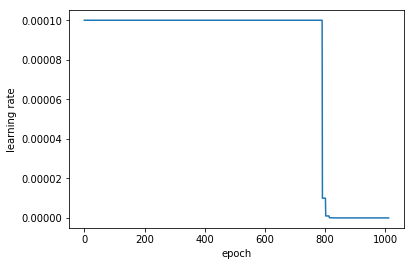

In [32]:
plt.plot(lr_list)
plt.xlabel("epoch")
plt.ylabel("learning rate")

Text(0, 0.5, 'MSE')

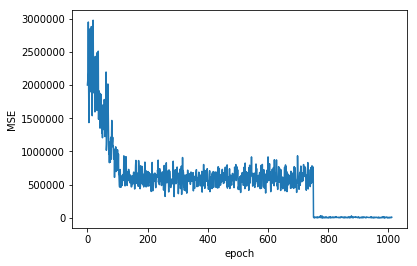

In [33]:
plt.plot(loss_list)
plt.xlabel("epoch")
plt.ylabel("MSE")

0.0001

#### 測試區

In [13]:
df.columns

Index(['id', 'idx', 'skin_b', 'skin_s', 'skin_w', 'skin_f', 'skin_m', 'fat_f',
       'muscle_b', 'muscle_s', 'muscle_w', 'ijv_s', 'cca_s', 'skin_musp',
       'skin_bmie', 'fat_musp', 'fat_bmie', 'muscle_musp', 'muscle_bmie',
       'ijv_musp', 'cca_musp', 'geo_skin', 'geo_fat', 'geo_ijvr', 'geo_ijvd',
       'geo_ccar', 'geo_ccad', 'geo_ijvcca'],
      dtype='object')

In [17]:
torch.tensor(df[["geo_skin", "geo_fat", "geo_ijvr", "geo_ijvd", "geo_ccar", "geo_ccad", "geo_ijvcca"]].values[1]
)

tensor([ 0.5557,  0.9685,  2.8096, 14.9084,  3.9205, 22.5811,  6.7432],
       dtype=torch.float64)

In [ ]:
spec = torch.rand(100, 29)
geo = torch.rand(100, 7)
y = model(spec, geo)
y.shape

In [2]:
x = np.load("train/spec/bU6cajDHxS/bU6cajDHxS.npy")

In [4]:
torch.tensor(x)

tensor([[1.0408e-06, 1.0324e-06, 1.0034e-06, 9.5299e-07, 9.3924e-07, 9.5263e-07,
         9.7319e-07, 9.3268e-07, 8.8969e-07, 8.7825e-07, 8.4541e-07, 8.1464e-07,
         7.6760e-07, 7.7507e-07, 7.6680e-07, 7.4076e-07, 7.1105e-07, 7.1413e-07,
         6.6429e-07, 6.4713e-07, 6.2505e-07, 6.2822e-07, 6.0908e-07, 5.9282e-07,
         5.6927e-07, 5.9081e-07, 5.6350e-07, 5.2947e-07, 5.1831e-07],
        [6.9771e-07, 6.8707e-07, 6.8903e-07, 7.2644e-07, 6.9338e-07, 6.9638e-07,
         6.8564e-07, 6.7437e-07, 6.0486e-07, 5.8981e-07, 5.6721e-07, 5.2133e-07,
         5.4799e-07, 5.4664e-07, 5.4748e-07, 5.0134e-07, 4.9878e-07, 4.8709e-07,
         4.7273e-07, 4.6758e-07, 4.2331e-07, 4.6610e-07, 4.2094e-07, 4.1544e-07,
         3.9125e-07, 3.7711e-07, 3.7129e-07, 3.6829e-07, 3.1805e-07],
        [3.6464e-07, 3.4948e-07, 3.5824e-07, 3.4661e-07, 3.6648e-07, 3.5867e-07,
         3.1745e-07, 3.2999e-07, 3.4104e-07, 3.1161e-07, 2.7153e-07, 2.8408e-07,
         2.8178e-07, 2.7281e-07, 2.6298e-07, 2.480